In [1]:
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import plotly
import datetime
import seaborn as sns

from utils import market_values, market_values_by_time_index

In [2]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
# find snap with easy determination of marginal generator
n.generators_t.p

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 ror,AT0 0 solar,AT0 1 onwind,AT0 1 ror,AT0 1 solar,AT0 2 onwind,...,RS0 1 solar rooftop,SE3 0 solar rooftop,SE3 1 solar rooftop,SE3 2 solar rooftop,SE3 3 solar rooftop,SE3 5 solar rooftop,SE3 6 solar rooftop,SE3 7 solar rooftop,SI0 0 solar rooftop,SK0 0 solar rooftop
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,4917.113011,444.933907,0.000000,0.000160,102.555845,0.000000,0.000317,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,4623.535568,444.620944,0.000000,0.000105,102.483658,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.000000,4795.128080,3455.948969,444.467881,792.324661,0.000061,102.448376,1207.124091,0.000000,...,365.072843,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,352.259879,523.284014
2013-01-01 09:00:00,0.000000,0.000000,11509.646090,1471.522842,444.478772,2989.259557,0.000000,102.450821,5691.630927,0.000000,...,1074.839751,1.210543,0.0,0.000619,0.035075,0.0,2.337271,0.0,1407.871519,1858.687944
2013-01-01 12:00:00,0.000000,0.000000,6377.253396,497.291894,447.815959,1678.141986,0.000000,103.219830,4162.664607,0.000000,...,577.275672,0.269088,0.0,0.000000,0.017729,0.0,0.533430,0.0,862.907142,875.497826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000000,0.000000,4911.200758,448.489909,549.709582,1048.040739,0.000000,126.698785,4358.484623,0.000000,...,944.298303,0.260902,0.0,0.000000,0.150806,0.0,0.258412,0.0,130.935906,886.166876
2013-12-31 12:00:00,0.000000,0.000000,2989.734046,1290.876086,548.017655,710.217489,0.000000,126.316122,2908.464725,0.000000,...,407.896036,0.000000,0.0,0.000000,0.047555,0.0,0.000000,0.0,113.992430,544.052274
2013-12-31 15:00:00,0.000000,0.000000,0.000000,1932.721807,546.870825,0.000000,0.000000,126.052526,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [44]:
# example of bus and snapshot
bus = "DE0 3" # "AL0 0" # "DE0 1"
snapshot = "2013-01-01 09:00:00"
# energy carrier at bus
n.buses.carrier[bus]

'AC'

In [45]:
# active power at bus (positive if net generation at bus) in MW
n.buses_t.p.loc[snapshot,bus]

3597.636983602783

In [46]:
# Lines (what reaches bus?)
# 1. sum of power @ lines with bus as bus0 and p0 (Active power at bus0 (positive if branch is withdrawing power from bus0)
n.lines_t.p0[n.lines[n.lines.bus0 == bus].index].sum(axis=1)
# 2. sum of power @ lines with bus as bus1 and p1 (Active power at bus1 (positive if branch is withdrawing power from bus1)
n.lines_t.p1[n.lines[n.lines.bus1 == bus].index].sum(axis=1)
# sum (if negative power is feed into bus)
lines = n.lines_t.p0[n.lines[n.lines.bus0 == bus].index].sum(axis=1) + n.lines_t.p1[n.lines[n.lines.bus1 == bus].index].sum(axis=1)
# sum should be the same value as the active power at the bus (links are not recognized yet?)
lines[snapshot]

3597.636983433492

In [6]:
# loads
loads_index = n.loads[[s in buses for s in n.loads.bus]].bus.index
# active power at bus (positive if net load) in MW
n.loads_t.p.loc[snapshot, loads_index]#.sum()

Load
AL0 0                                      238.642397
AL0 0 land transport EV                    276.317265
AL0 0 land transport fuel cell              92.174636
AL0 0 residential rural heat               353.901262
AL0 0 services rural heat                   86.803240
AL0 0 residential urban decentral heat     150.374273
AL0 0 services urban decentral heat         36.883096
AL0 0 urban central heat                   323.018962
AL0 0 H2 for industry                        3.424658
AL0 0 H2 for shipping                       21.714866
AL0 0 low-temperature heat for industry      4.566210
AL0 0 industry electricity                 206.621005
AL0 0 agriculture electricity                0.000000
AL0 0 agriculture heat                       0.000000
Name: 2013-01-01 09:00:00, dtype: float64

In [7]:
# generation in whole region
gens_index = n.generators[[s in buses for s in n.generators.bus]].bus.index
# active power at bus (positive if net generation) in MW
n.generators_t.p.loc[snapshot, gens_index]#.sum(axis=1)

Generator
AL0 0 offwind-ac                                                 0.000000
AL0 0 onwind                                                     0.000000
AL0 0 solar                                                  11509.646090
AL0 0 residential rural solar thermal collector                  0.024807
AL0 0 services rural solar thermal collector                     0.025474
AL0 0 residential urban decentral solar thermal collector        0.043897
AL0 0 services urban decentral solar thermal collector           0.043574
AL0 0 urban central solar thermal collector                     56.779796
AL0 0 solar rooftop                                           1343.090499
Name: 2013-01-01 09:00:00, dtype: float64

In [8]:
# generation directly connected to bus
gens_index_direct = n.generators[n.generators.bus == bus].bus.index
n.generators_t.p.loc[snapshot, gens_index_direct]#.sum(axis=1)

Generator
AL0 0 offwind-ac        0.00000
AL0 0 onwind            0.00000
AL0 0 solar         11509.64609
Name: 2013-01-01 09:00:00, dtype: float64

In [9]:
# storages
storage_index = n.storage_units[[s in buses for s in n.storage_units.bus]].bus.index
# active power at bus (positive if net generation) in MW
n.storage_units_t.p.loc[snapshot, storage_index]#.sum(axis=1)

Series([], Name: 2013-01-01 09:00:00, dtype: float64)

In [10]:
# storage directly at bus
storage_index_direct = n.storage_units[n.storage_units.bus == bus].bus.index
n.storage_units_t.p.loc[snapshot, storage_index_direct]#.sum(axis=1)

Series([], Name: 2013-01-01 09:00:00, dtype: float64)

In [11]:
# stores
stores_index = n.stores[[s in buses for s in n.stores.bus]].bus.index
# active power at bus (positive if net generation) in MW
n.stores_t.p.loc[snapshot, stores_index]#.sum(axis=1)

Store
AL0 0 H2 Store                                  -2239.255897
AL0 0 battery                                   -4362.526812
AL0 0 battery storage                           -1122.461043
AL0 0 residential rural water tanks                -0.024873
AL0 0 services rural water tanks                   -0.024912
AL0 0 residential urban decentral water tanks      -0.008021
AL0 0 services urban decentral water tanks         -0.007804
AL0 0 urban central water tanks                    -0.004985
AL0 0 home battery                                 -0.087006
Name: 2013-01-01 09:00:00, dtype: float64

In [12]:
# stores directly at bus
stores_index_direct = n.stores[n.stores.bus == bus].bus.index
# active power at bus (positive if net generation) in MW
n.stores_t.p.loc[snapshot, stores_index_direct]#.sum(axis=1)

Series([], Name: 2013-01-01 09:00:00, dtype: float64)

In [13]:
# link

In [14]:
n.links[n.links.bus0 == bus]

,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,p_nom_opt,charger_ratio,type,build_year,p_nom_min,p_set,p_max_pu,terrain_factor,ramp_limit_up,ramp_limit_down
Link,,,,,,,,,,,,,,,,,,,,,
AL0 0 H2 Electrolysis,AL0 0,AL0 0 H2,H2 Electrolysis,,0.0,0.0,,NaN,NaN,0.0,...,3811.499287,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
AL0 0 battery charger,AL0 0,AL0 0 battery,battery charger,,0.0,0.0,,NaN,NaN,0.0,...,4452.493618,-1.664988,,0,0.0,0.0,1.0,1.0,NaN,NaN
AL0 0 electricity distribution grid,AL0 0,AL0 0 low voltage,electricity distribution grid,,0.0,0.0,,NaN,NaN,-1.0,...,884.187798,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN


In [15]:
n.links_t.p0.loc[snapshot, n.links[n.links.bus0 == bus].index]

Link
AL0 0 H2 Electrolysis                  3792.122835
AL0 0 battery charger                  4452.490551
AL0 0 electricity distribution grid     884.184940
Name: 2013-01-01 09:00:00, dtype: float64

In [16]:
n.links[n.links.bus1 == bus]

,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,p_nom_opt,charger_ratio,type,build_year,p_nom_min,p_set,p_max_pu,terrain_factor,ramp_limit_up,ramp_limit_down
Link,,,,,,,,,,,,,,,,,,,,,
AL0 0 OCGT,EU gas,AL0 0,OCGT,,0.0,0.0,,NaN,NaN,0.0,...,0.233304,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
AL0 0 H2 Fuel Cell,AL0 0 H2,AL0 0,H2 Fuel Cell,,0.0,0.0,,NaN,NaN,0.0,...,0.028772,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
AL0 0 battery discharger,AL0 0 battery,AL0 0,battery discharger,,0.0,0.0,,NaN,NaN,0.0,...,4544.306793,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
AL0 0 urban central gas CHP,EU gas,AL0 0,urban central gas CHP,,0.0,0.0,,NaN,NaN,0.0,...,104.366725,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
AL0 0 urban central gas CHP CC,EU gas,AL0 0,urban central gas CHP CC,,0.0,0.0,,NaN,NaN,0.0,...,0.085156,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
AL0 0 urban central solid biomass CHP,EU solid biomass,AL0 0,urban central solid biomass CHP,,0.0,0.0,,NaN,NaN,0.0,...,0.071155,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
AL0 0 urban central solid biomass CHP CC,EU solid biomass,AL0 0,urban central solid biomass CHP CC,,0.0,0.0,,NaN,NaN,0.0,...,96.324958,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN


In [17]:
n.links_t.p1.loc[snapshot, n.links[n.links.bus1 == bus].index]

Link
AL0 0 OCGT                                  -0.001165
AL0 0 H2 Fuel Cell                          -0.003703
AL0 0 battery discharger                    -0.005506
AL0 0 urban central gas CHP                 -0.002643
AL0 0 urban central gas CHP CC              -0.009589
AL0 0 urban central solid biomass CHP       -0.015686
AL0 0 urban central solid biomass CHP CC   -25.043738
Name: 2013-01-01 09:00:00, dtype: float64

In [18]:
# Links (what reaches bus?)
# 1. sum of power @ links with bus as bus0 and p0 (Active power at bus0 (positive if branch is withdrawing power from bus0)
n.links_t.p0[n.links[n.links.bus0 == bus].index].sum(axis=1)
# 2. sum of power @ links with bus as bus1 and p1 (Active power at bus1 (positive if branch is withdrawing power from bus1)
n.links_t.p1[n.links[n.links.bus1 == bus].index].sum(axis=1)
# sum (if negative power is feed into bus)
links_sum = n.links_t.p0[n.links[n.links.bus0 == bus].index].sum(axis=1) + n.links_t.p1[n.links[n.links.bus1 == bus].index].sum(axis=1)
links_sum[snapshot]

9103.716295723527

In [19]:
n.links_t.p0.loc[snapshot , n.links[n.links.bus0 == bus].index]

Link
AL0 0 H2 Electrolysis                  3792.122835
AL0 0 battery charger                  4452.490551
AL0 0 electricity distribution grid     884.184940
Name: 2013-01-01 09:00:00, dtype: float64

In [20]:
n.links_t.p1.loc[snapshot, n.links[n.links.bus1 == bus].index]

Link
AL0 0 OCGT                                  -0.001165
AL0 0 H2 Fuel Cell                          -0.003703
AL0 0 battery discharger                    -0.005506
AL0 0 urban central gas CHP                 -0.002643
AL0 0 urban central gas CHP CC              -0.009589
AL0 0 urban central solid biomass CHP       -0.015686
AL0 0 urban central solid biomass CHP CC   -25.043738
Name: 2013-01-01 09:00:00, dtype: float64

In [21]:
# aggregation for bus0
# balance of electricity feed in and withdrawal via lines
li = lines[snapshot]
# load at direct bus (no other technologies)
lo = n.loads_t.p.loc[snapshot, loads_index][bus].sum()
# generation at direct bus (no other technologies)
gen = n.generators_t.p.loc[snapshot, gens_index_direct].sum()
# storage directly at bus
sg = n.storage_units_t.p.loc[snapshot, storage_index_direct].sum()
# stores directl at bus
st = n.stores_t.p.loc[snapshot, stores_index_direct].sum()
# balance of links between different technologies
lk = links_sum[snapshot]
print(f"{gen} + {sg} + {st} - {li} - {lk} - {lo}")

gen + sg + st - li - lk - lo

11509.646090030108 + 0.0 + 0.0 - 2405.9273368603926 - 9103.716295723527 - 238.6423970096223


-238.6399395634328

In [22]:
n.loads_t.p.loc[snapshot, loads_index][bus]

238.6423970096223

In [23]:
# active power at the bus has to be the same as the balance of the lines
print(li, n.buses_t.p.loc[snapshot, bus])

2405.9273368603926 2405.927336882239


In [24]:
# suche kraftwerk, das läuft aber nicht mit voller kapa
# lmp

In [25]:
n.global_constraints

,type,carrier_attribute,sense,constant,mu,investment_period
GlobalConstraint,,,,,,
lv_limit,transmission_volume_expansion_limit,"AC, DC",<=,3.222256e+08,NaN,NaN
CO2Limit,primary_energy,co2_emissions,<=,0.000000e+00,513.293385,NaN
co2_sequestration_limit,nan,nan,<=,2.000000e+08,338.688272,NaN


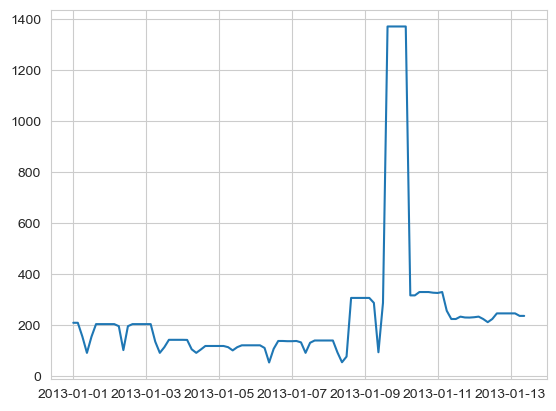

In [26]:
plt.plot(n.buses_t.marginal_price[["AL0 0"]][0:100])

In [27]:
# find snap with easy determination of marginal generator
n.generators_t.p

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 ror,AT0 0 solar,AT0 1 onwind,AT0 1 ror,AT0 1 solar,AT0 2 onwind,...,RS0 1 solar rooftop,SE3 0 solar rooftop,SE3 1 solar rooftop,SE3 2 solar rooftop,SE3 3 solar rooftop,SE3 5 solar rooftop,SE3 6 solar rooftop,SE3 7 solar rooftop,SI0 0 solar rooftop,SK0 0 solar rooftop
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,4917.113011,444.933907,0.000000,0.000160,102.555845,0.000000,0.000317,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,4623.535568,444.620944,0.000000,0.000105,102.483658,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.000000,4795.128080,3455.948969,444.467881,792.324661,0.000061,102.448376,1207.124091,0.000000,...,365.072843,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,352.259879,523.284014
2013-01-01 09:00:00,0.000000,0.000000,11509.646090,1471.522842,444.478772,2989.259557,0.000000,102.450821,5691.630927,0.000000,...,1074.839751,1.210543,0.0,0.000619,0.035075,0.0,2.337271,0.0,1407.871519,1858.687944
2013-01-01 12:00:00,0.000000,0.000000,6377.253396,497.291894,447.815959,1678.141986,0.000000,103.219830,4162.664607,0.000000,...,577.275672,0.269088,0.0,0.000000,0.017729,0.0,0.533430,0.0,862.907142,875.497826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000000,0.000000,4911.200758,448.489909,549.709582,1048.040739,0.000000,126.698785,4358.484623,0.000000,...,944.298303,0.260902,0.0,0.000000,0.150806,0.0,0.258412,0.0,130.935906,886.166876
2013-12-31 12:00:00,0.000000,0.000000,2989.734046,1290.876086,548.017655,710.217489,0.000000,126.316122,2908.464725,0.000000,...,407.896036,0.000000,0.0,0.000000,0.047555,0.0,0.000000,0.0,113.992430,544.052274
2013-12-31 15:00:00,0.000000,0.000000,0.000000,1932.721807,546.870825,0.000000,0.000000,126.052526,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [28]:
n.buses_t.marginal_price

Bus,AL0 0,AL0 0 EV battery,AL0 0 H2,AL0 0 H2 liquid,AL0 0 battery,AL0 0 home battery,AL0 0 low voltage,AL0 0 residential rural heat,AL0 0 residential rural water tanks,AL0 0 residential urban decentral heat,...,SK0 0 services rural water tanks,SK0 0 services urban decentral heat,SK0 0 services urban decentral water tanks,SK0 0 urban central heat,SK0 0 urban central water tanks,co2 atmosphere,co2 stored,gas for industry,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,208.089324,187.447538,132.306353,87210.617893,203.956540,207.193448,208.101095,56.974139,58.124200,98.687337,...,37.759799,125.280135,118.864605,118.047631,100.123259,-513.283465,-358.677321,113.318707,-414.293975,78.325642
2013-01-01 03:00:00,208.030183,187.447686,132.305622,132.315961,203.902052,205.714306,208.041610,57.018315,60.356861,231.005065,...,123.354232,131.588893,127.508619,119.289047,100.193499,-513.283465,-358.677360,113.334089,-412.864209,78.419905
2013-01-01 06:00:00,153.808216,187.447826,132.304178,132.314517,156.989409,169.934834,168.694456,185.978154,162.287216,187.391199,...,127.469042,131.586472,131.094079,119.372125,100.263177,-513.283465,-358.677378,113.349609,-412.188901,78.490917
2013-01-01 09:00:00,89.821566,182.553882,132.127980,132.138319,156.989293,167.097474,164.289516,45.035153,48.301899,125.271125,...,125.676186,125.283858,128.344296,119.430310,100.331808,-513.283465,-358.677391,113.365708,-411.875232,78.559337
2013-01-01 12:00:00,153.339481,182.554338,132.303825,132.314163,156.989346,167.635541,164.290191,45.045361,48.062406,125.255829,...,124.979069,125.281745,128.271108,119.428606,100.400904,-513.283465,-358.677399,113.395103,-411.642917,78.642735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,199.844657,187.446471,132.308110,132.318449,203.986154,201.531371,199.854464,56.431556,57.994492,79.089352,...,37.617372,125.278126,126.196737,118.054180,99.774169,-513.283465,-358.677308,112.957515,-407.839459,78.502628
2013-12-31 12:00:00,199.855407,187.446782,132.308083,132.318421,203.986169,202.085946,199.865679,56.451729,58.044303,77.418336,...,36.567638,125.275258,125.383352,118.052955,99.843746,-513.283465,-358.677296,112.949373,-407.825246,78.497642
2013-12-31 15:00:00,208.203744,187.447032,132.307921,132.318259,203.986319,206.444218,208.217403,58.830340,58.841772,125.150310,...,37.770381,125.276215,123.458995,118.054432,99.913423,-513.283465,-358.677267,112.944123,-407.815666,78.487410


In [29]:
n.generators.loc["AL0 0 solar"]

p_nom_max               53368.632501
weight                   2347.489775
p_nom                            0.0
capital_cost            48788.865309
carrier                        solar
marginal_cost                0.01938
efficiency                       1.0
p_nom_extendable                True
bus                            AL0 0
control                             
p_nom_opt                22582.11171
lifetime                         inf
type                                
p_nom_min                        0.0
p_min_pu                         0.0
p_max_pu                         1.0
p_set                            0.0
q_set                            0.0
sign                             1.0
build_year                         0
committable                    False
start_up_cost                    0.0
shut_down_cost                   0.0
min_up_time                        0
min_down_time                      0
up_time_before                     1
down_time_before                   0
r